In [1]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install lime

%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#importando pacotes e bibliotecas para um SVM

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
#from sklearn.feature_extraction.text import CountVectorizer #converter os textos em uma matriz
from sklearn.feature_extraction.text import TfidfTransformer #frequencia que o termo aparece
from lime.lime_text import LimeTextExplainer

#from sklearn.svm import LinearSVC, SVC # dados lineares / não lineares
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [3]:
#importando dataset

df = pd.read_csv("all-data.csv")

In [4]:
df.head(5)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
df.shape

(4846, 2)

<Axes: xlabel='sentiment', ylabel='count'>

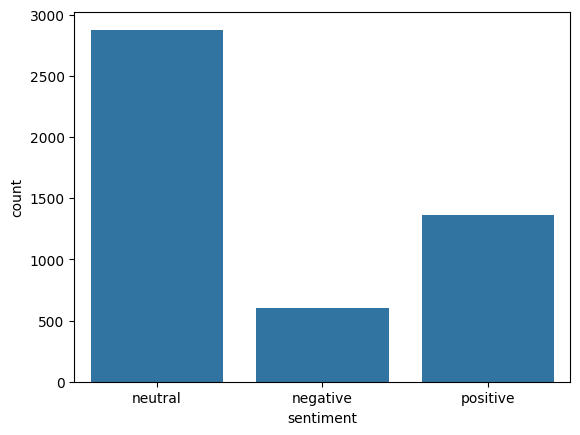

In [6]:
#exibindo os dados em um gráfico de barras
sns.countplot(x='sentiment', data=df)

**Pré-processamento**

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [9]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [10]:
df.head(5)

,sentiment,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year baswar...


<Axes: xlabel='sentiment', ylabel='count'>

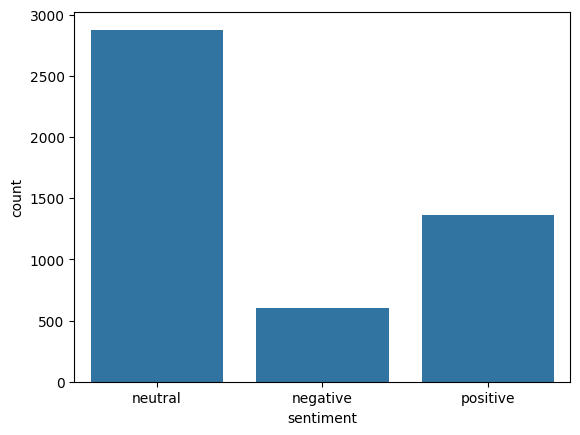

In [11]:
sns.countplot(x="sentiment", data=df) # validando se mudou as classes

**UNDERSAMPLING**

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Separar features e rótulos
X = df["clean_text"]
y = df["sentiment"]

# Dividir em treino e teste antes do balanceamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vetorização dos textos (CountVectorizer)
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)  # Apenas transform, sem fit

# Aplicar undersampling APENAS no conjunto de treino
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_vect, y_train)

<Axes: xlabel='sentiment', ylabel='count'>

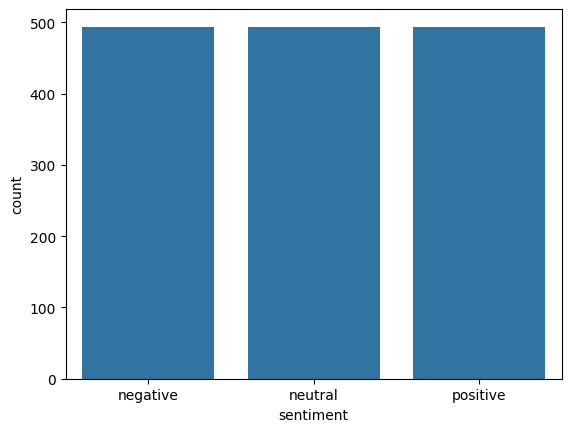

In [13]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

TREINAMENTO

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from imblearn.under_sampling import RandomUnderSampler

# Pipeline completo (inclui vetorização)
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

# Balanceamento APENAS no treino
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train.to_frame(), y_train)
X_train_resampled = X_train_resampled.squeeze()  # volta para Series

# Treinamento do pipeline
pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

In [15]:
# Realiza a predição no conjunto de teste
y_pred = pipeline.predict(X_test)

**LIME**

In [16]:
# Assuming 'text' is the column name containing the text data and 'sentiment' is the target column
X = df['text']
y = df['sentiment']

In [17]:
#X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["sentiment"], test_size=0.2, random_state=42)

In [18]:
from IPython.display import display
from lime.lime_text import LimeTextExplainer

# Criando o explainer
explainer = LimeTextExplainer(class_names=list(pipeline.classes_))

def predict_proba(texts):
    # LIME espera probabilidades, mas LinearSVC não tem predict_proba.
    # Usamos decision_function e normalizamos para somar 1 (softmax-like).
    scores = pipeline.decision_function(texts)
    import numpy as np
    # Se for 1D (binary), transforma em 2D
    if len(scores.shape) == 1:
        scores = np.vstack([-scores, scores]).T
    # Softmax para converter scores em "probabilidades"
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
    return probs

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
pred_class_name = pipeline.predict([sample_text])[0]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Real class: {sample_label}")
print(f"Classe predita: {pred_class_name}")


explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

Número da linha no X_test: 499
Original text:
preliminary estimation technology park measure square meter
Real class: neutral
Classe predita: neutral


In [19]:
import matplotlib.pyplot as plt

# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")


Palavras mais importantes e seus pesos:
square: 0.0992
park: -0.0549
technology: -0.0516
estimation: 0.0406
preliminary: 0.0370
meter: 0.0312
measure: 0.0085


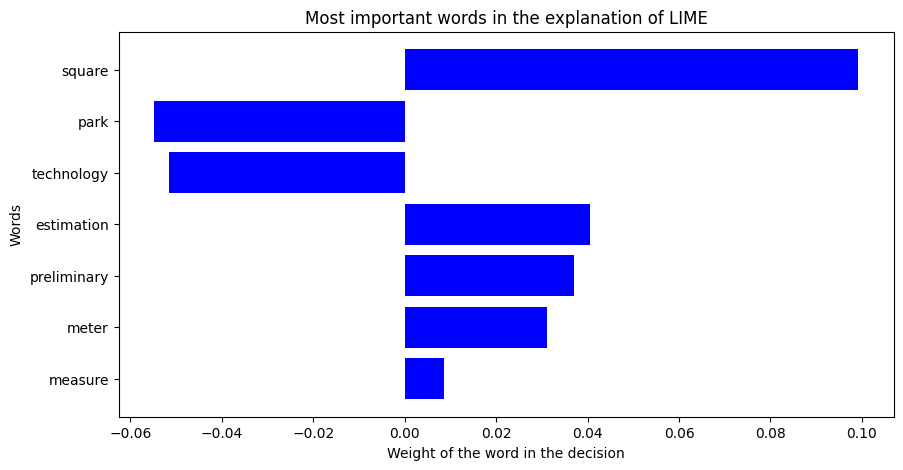

In [20]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [21]:
explanation_list = explanation.as_list()
lime_df = pd.DataFrame(explanation_list, columns=["Word", "Impact"])

# Ordenar por impacto
lime_df = lime_df.sort_values(by="Impact", ascending=False)

display(lime_df.head(20))  # Exibir as 20 palavras mais impactantes

,Word,Impact
0,square,0.099243
3,estimation,0.040554
4,preliminary,0.036985
5,meter,0.031174
6,measure,0.008543
2,technology,-0.051552
1,park,-0.054860


<Figure size 1000x600 with 0 Axes>

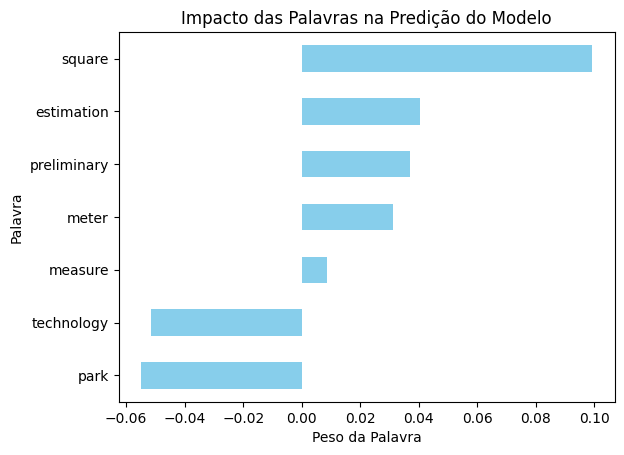

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
lime_df.plot(kind="barh", x="Word", y="Impact", color="skyblue", legend=False)
plt.xlabel("Peso da Palavra")
plt.ylabel("Palavra")
plt.title("Impacto das Palavras na Predição do Modelo")
plt.gca().invert_yaxis()  # Inverte o eixo para as palavras mais importantes ficarem no topo
plt.show()

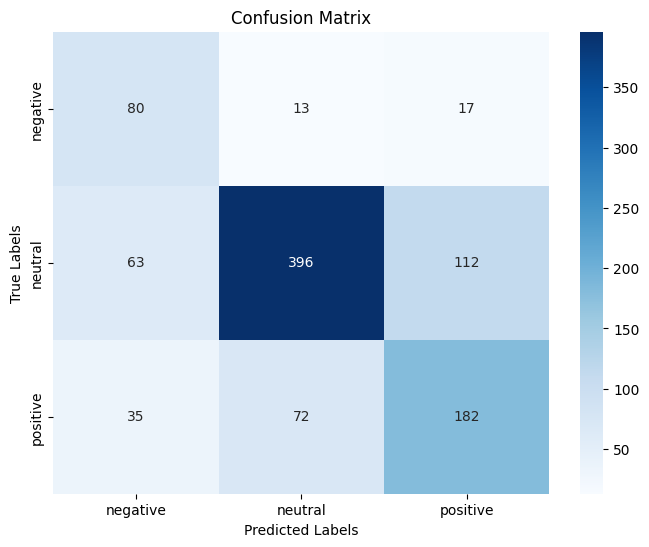

In [23]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


**Métricas**

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import necessary metrics

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Usando 'weighted' para classes múltiplas
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Acuraccy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acuraccy: 0.6784
Precision: 0.7100
Recall: 0.6784
F1-Score: 0.6869


**Attention Vizualization**

In [25]:
print(pipeline.classes_)

['negative' 'neutral' 'positive']


Palavras do exemplo e seus pesos na decisão da classe prevista:
          Feature    Weight
3512       square  0.587180
1188   estimation  0.254300
2865  preliminary  0.251252
2296        meter  0.217478
2259      measure  0.199807
2685         park -0.172924
3740   technology -0.275615


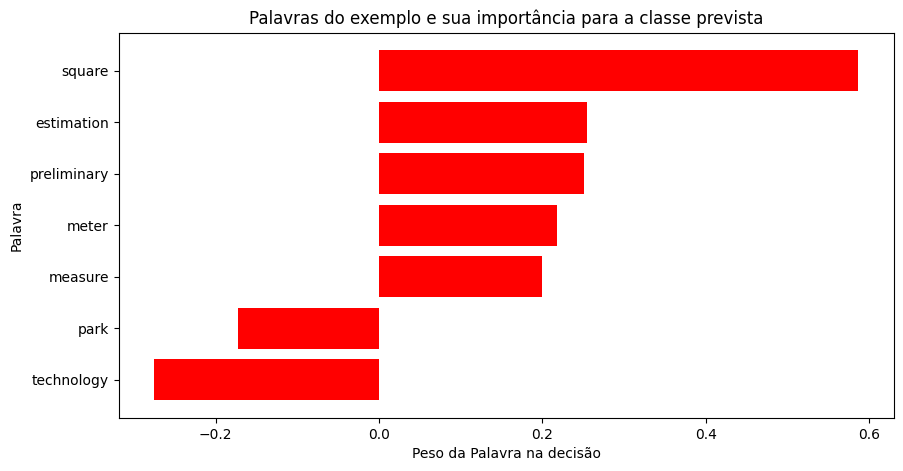

In [26]:
# Obter os nomes das features do CountVectorizer
feature_names = pipeline.named_steps['vect'].get_feature_names_out()

# Obter os coeficientes do SVM para a classe prevista
classe_prevista = pipeline.predict([sample_text])[0]
classe_idx = list(pipeline.classes_).index(classe_prevista)
pesos = pipeline.named_steps['clf'].coef_[classe_idx]

# Criar DataFrame com as features e pesos
importancias = pd.DataFrame({'Feature': feature_names, 'Weight': pesos})

# Marcar as palavras do exemplo
palavras_exemplo = set(sample_text.split())
importancias['No_Exemplo'] = importancias['Feature'].apply(lambda x: x in palavras_exemplo)

# Visualizar as palavras do exemplo e seus pesos
importancias_exemplo = importancias[importancias['No_Exemplo']].sort_values(by='Weight', ascending=False)

print("Palavras do exemplo e seus pesos na decisão da classe prevista:")
print(importancias_exemplo[['Feature', 'Weight']])

# Plotar as palavras do exemplo
plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo['Feature'], importancias_exemplo['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title("Palavras do exemplo e sua importância para a classe prevista")
plt.gca().invert_yaxis()
plt.show()

In [27]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline.named_steps['clf'].coef_[0]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

          Feature    Weight
895     decreased  3.759595
1299         fell  2.957072
3142       result  2.016619
1036      dropped  2.006689
891      declined  1.944949
2150        lower  1.875735
851           cut  1.782018
1557         half  1.723158
3436      slipped  1.521669
1272         fall  1.494044
3523        staff  1.491266
2437     negative  1.463855
2040       layoff  1.421760
4103         weak  1.330235
4161       worker  1.283105
4121         went  1.261137
1043          due  1.250135
508      canceled  1.248212
3766  temporarily  1.233639
894      decrease  1.212158


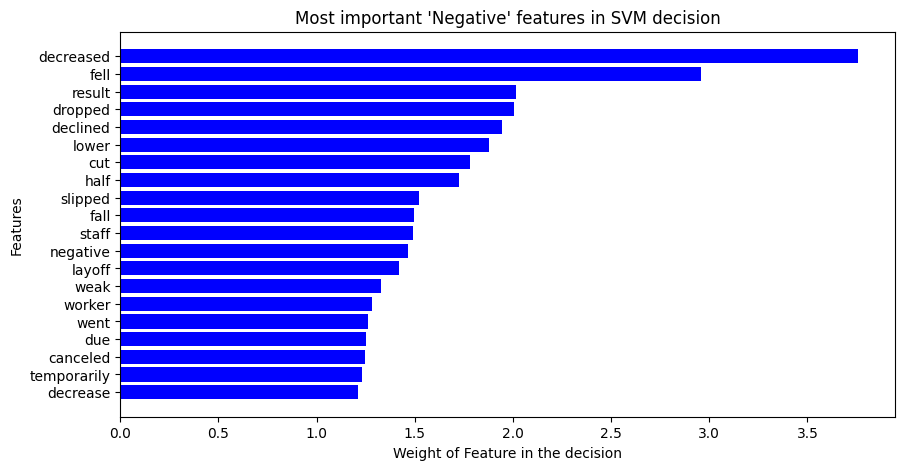

In [28]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Negative' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [29]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline.named_steps['clf'].coef_[1]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

            Feature    Weight
198   approximately  1.515556
2877      president  1.310005
4024          value  1.191027
2663             oy  1.188684
1722       includes  1.186998
2551          offer  1.149799
27         acquired  1.127527
2206    manufacture  1.109220
3124       research  1.060655
978       disclosed  1.046994
3269      scheduled  1.036546
2571           olvi  1.031600
1394      following  1.026795
280       available  1.022951
1476        gearing  1.009453
1594  headquartered  1.004238
977        disclose  1.002575
874            date  0.978634
793            corp  0.970150
907       delivered  0.969764


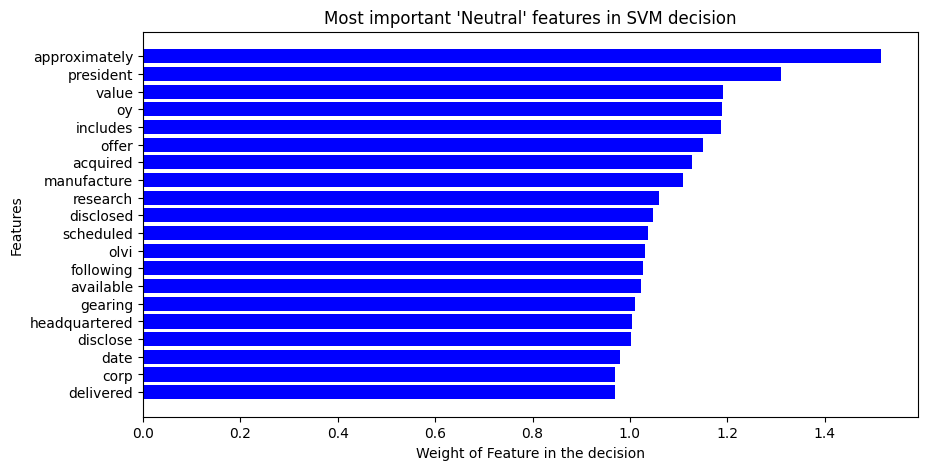

In [30]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Neutral' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [31]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline.named_steps['clf'].coef_[2]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
import pandas as pd
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

          Feature    Weight
3192         rose  2.742412
1728    increased  2.355594
3394       signed  2.110026
1528         grew  2.084118
1709     improved  2.005987
2838     positive  1.991164
1727     increase  1.988872
1541       growth  1.524758
1509         good  1.464077
3020        reach  1.333363
1227       expand  1.325952
2943      provide  1.276784
1578        happy  1.269572
102           aim  1.262404
3560        still  1.218088
1710  improvement  1.213591
1230    expansion  1.165887
2045      leading  1.164359
1229      expands  1.157062
904     delighted  1.156316


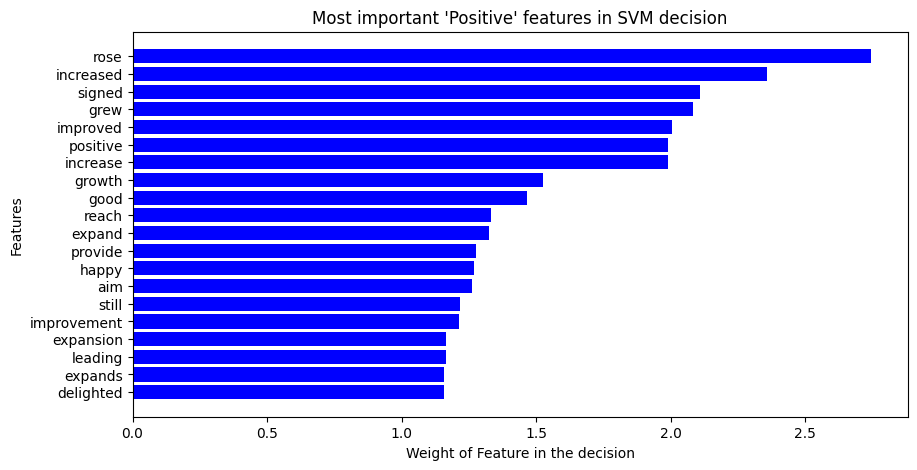

In [32]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Positive' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [37]:
#contar a distribuição das classes pós balanceamento em tabela
class_distribution = pd.Series(y_train_resampled).value_counts()
class_distribution2 = pd.Series(y_test).value_counts()

# Exibir a distribuição das classes
print("Distribuição das classes após balanceamento:")
print(class_distribution)

print("Distribuição das classes de teste:")
print(class_distribution2)

Distribuição das classes após balanceamento:
sentiment
negative    494
neutral     494
positive    494
Name: count, dtype: int64
Distribuição das classes de teste:
sentiment
neutral     571
positive    289
negative    110
Name: count, dtype: int64
